Scripts for Identifying Supply and Demand Zones for Stocks

In [3]:
# Imports
!pip install mplfinance
import numpy as np
import pandas as pd
import tensorflow as tf
import mplfinance as mpl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Load Data
spy_hourly = pd.DataFrame(np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/SPY_1hour.txt', header=None)), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
spy_thirty_min = pd.DataFrame(np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/SPY_30min.txt', header=None)), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
five_min_data = pd.DataFrame(np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/SPY_5min.txt', header=None)), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [5]:
# Helper Functions
def get_change(candle):
  diff = candle[4]/candle[1]
  if candle[4] > candle[1]:
    change = diff - 1
  else:
    change = 1 - diff

  return change

def no_long_wicks(candle, thresh_pct):
  thresh = thresh_pct*get_change(candle)
  candle_open, candle_high, candle_low, candle_close = candle[1], candle[2], candle[3], candle[4]
  if candle_close > candle_open:
    if candle_high/candle_close - 1 < thresh and candle_open/candle_low - 1 < thresh:
      return True
  else:
    if candle_high/candle_open - 1 < thresh and candle_close/candle_low - 1 < thresh:
      return True
  return False


def is_basing(candle, next_candle_change, thresh_pct):
  """ Criterion for basing candle
  1. Must be less than half of the next candle
  """
  if get_change(candle) > 0.5*next_candle_change:
    return False
  
  """ 
  2. Must have small wicks, meaning if it is a green candle, high is close to 
  close and low is close to open, and if it is red, then vice versa.

  "Closeness" is dependent on the candle's change. Define closeness threshold as within thresh_pct of the candle's change 
  """
  return no_long_wicks(candle, thresh_pct)

In [6]:
def is_zone(candle, next_candle, large_change, thresh_pct, supply, demand):

  # Criterion for Supply/Demand Zone:
  # 1. Next candle must have large % change between open and close
  if get_change(next_candle) >= large_change:
    # 2. Next candle must not have long wicks
    if no_long_wicks(next_candle, thresh_pct):
      # 3. Must have basing candle
      if is_basing(candle, get_change(next_candle), thresh_pct):
        if next_candle[4] > next_candle[1] and demand:
          return True
        elif next_candle[4] < next_candle[1] and supply:
          return True
  return False

In [7]:
def get_zones(data, large_change, thresh_pct, supply, demand):
  zones = []
  for i in range(len(data.values)):
    if i + 1 < len(data.values):
      candle = data.values[i]
      next_candle = data.values[i + 1]
      if is_zone(candle, next_candle, large_change, thresh_pct, supply, demand):
          zones.append([candle, next_candle])
  return np.array(zones)

In [13]:
zones = get_zones(spy_thirty_min, 0.003, 0.5, True, True)
print(zones.shape)

(775, 2, 6)


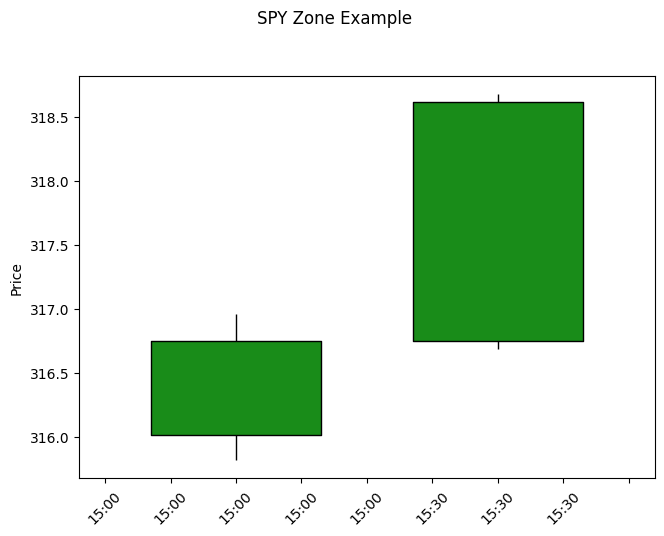

In [25]:
# Sample of a Random Zone
random = np.random.randint(0, len(zones) - 1)
plot_zones = zones[random]
plot_zones = pd.DataFrame(plot_zones[:, [1, 2, 3, 4]], columns=['Open', 'High', 'Low', 'Close'], index=pd.to_datetime(plot_zones[:, 0])).astype('float32')
mc = mpl.make_marketcolors(up='green',down='red')
s  = mpl.make_mpf_style(marketcolors=mc)
mpl.plot(
    plot_zones,
    type="candle", 
    style=s,
    mav = (10000),
    title = f"SPY Zone Example",  
    )